In [7]:
#-------Plot Chandra photometry data-------#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from astropy.table import Table
import scipy, pylab
from scipy.integrate import trapz, simps, quad
import math
import astropy
import pyregion
from matplotlib.lines import Line2D
from astropy.io import fits
import matplotlib.cm as cmx
import matplotlib.colors as colors

wittmann = Table.read('wittmann-2017.csv')
netcounts11714 = Table.read('netcounts/11714_netcounts.csv')
netcounts11715 = Table.read('netcounts/11715_netcounts.csv')
netcounts11713 = Table.read('netcounts/11713_netcounts.csv')
songcounts = Table.read('netcounts/song_netcounts.csv')

netcounts1 = np.append(netcounts11713['net_counts'], netcounts11714['net_counts']) 
netcounts1 = np.append(netcounts1, netcounts11715['net_counts'])  
netcounts1 = np.append(netcounts1, songcounts['net_counts'])                                    # all netcount info

yupp1 = np.append(netcounts11713['upper_err'], netcounts11714['upper_err'])   				  # Set upper and lower limits from csv files
yupp1 = np.append(yupp1, netcounts11715['upper_err'])
yupp1 = np.append(yupp1, songcounts['upper_err'])

ylow = np.append(netcounts11713['lower_err'], netcounts11714['lower_err'])
ylow = np.append(ylow, netcounts11715['lower_err'])
ylow1 = np.append(ylow, songcounts['lower_err'])
           
ra1 = np.append(netcounts11713['ra'], netcounts11714['ra'])
ra1 = np.append(ra1, netcounts11715['ra'])
ra1 = np.append(ra1, songcounts['ra'])

dec1 = np.append(netcounts11713['dec'], netcounts11714['dec'])
dec1 = np.append(dec1, netcounts11715['dec'])
dec1 = np.append(dec1, songcounts['dec'])

idarray = np.append(netcounts11713['chandra_ID'], netcounts11714['chandra_ID'])
idarray = np.append(idarray, netcounts11715['chandra_ID'])
idarray = np.append(idarray, (songcounts['chandra_ID']))

#-----define a distance function to get distances in degrees between two objects given their ra,dec-----
def degreedist(ra1, dec1, ra2, dec2):
    ra2 = math.radians(ra2)
    dec2 = math.radians(dec2)
    ra1 = math.radians(ra1)
    dec1 = math.radians(dec1)
    cosdist = math.sin(dec1)*math.sin(dec2) + math.cos(dec1)*math.cos(dec2)*math.cos(ra1 - ra2)
    return math.degrees(math.acos(cosdist))

#-----filter out objects too far away from the target ra, dec of each Chandra Observation's fits file-----
#-----create an array of the indexes that fall within the desired distances
maxdist = 0.116667 # degrees
#maxdist = 2
indxs = []
def fits_file(imagenum):  # takes each file's number and returns a string fits filename
    if int(imagenum) < 1000:
        return 'FITSfiles/acisf00%s_repro_evt2.fits' %imagenum
    if int(imagenum) < 10000:
        return 'FITSfiles/acisf0%s_repro_evt2.fits' %imagenum
    else:
        return 'FITSfiles/acisf%s_repro_evt2.fits' %imagenum
    
len(idarray)


68

In [8]:
indxs = []
for id in range(len(ra1)):
    fname = fits_file(idarray[id])
    hdulist = fits.open(fname)
    hduheader = hdulist[1].header
    ra_targ = hduheader['RA_TARG']
    dec_targ = hduheader['DEC_TARG']
    
    dist = degreedist(ra1[id], dec1[id], ra_targ, dec_targ)
    if dist < maxdist:
        indxs.append(id)

In [9]:
# select attributes from objects within desired threshold
ra = np.zeros(len(indxs))
dec = np.zeros(len(indxs))
yupp = np.zeros(len(indxs))
ylow = np.zeros(len(indxs))
netcounts = np.zeros(len(indxs))

for i in range(len(indxs)):
    netcounts[i] = netcounts1[indxs[i]]
    yupp[i] = yupp1[indxs[i]]
    ylow[i] = ylow1[indxs[i]]
    ra[i] = ra1[indxs[i]]
    dec[i] = dec1[indxs[i]]
    
netcounts_300 = netcounts[0::2]     # separate by energy level (300kev-2000kev, 2000kev-7000kev)
netcounts_2000 = netcounts[1::2]
yupp_300 = yupp[0::2]
yupp_2000 = yupp[1::2]
ylow_300 = ylow[0::2]
ylow_2000 = ylow[1::2]
    
#-----compute distances from NGC1275-----
ra_NGC1275 = 49.95041666
dec_NGC1275 = 41.51138889
distarray = np.zeros(len(ra))
for i in range(len(ra)):
    distarray[i] = degreedist(ra[i], dec[i], ra_NGC1275, dec_NGC1275)

distarray = distarray[0::2]

len(distarray)
len(ra)


32

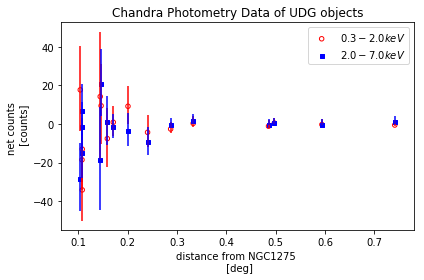

In [10]:
#------make the plot-----
ax1 = pylab.subplot(111)

ax1.scatter(distarray, netcounts_300, s=20, facecolors='none', edgecolors='r', label='$0.3-2.0 keV$')
ax1.scatter(distarray, netcounts_2000, s=20, c = 'b', marker = "s", label = '$2.0-7.0 keV$')

ax1.errorbar(distarray, netcounts_300, yerr=(ylow_300, yupp_300), linestyle='none', ecolor='r')
ax1.errorbar(distarray, netcounts_2000, yerr=(ylow_2000, yupp_2000), linestyle='none', ecolor='b')


#pylab.ylim([40.8, 42.0])
#pylab.xlim([])
plt.title('Chandra Photometry Data of UDG objects')
plt.xlabel('distance from NGC1275 \n [deg]')
plt.ylabel('net counts \n [counts]')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

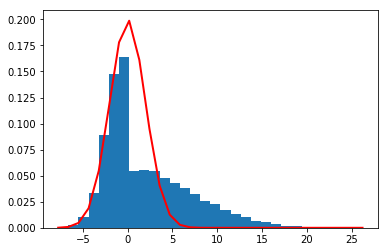

10000

In [48]:
from random import *
sigup = 7 # upper error bound (one sigma)
siglo = 2 # lower error bound (one sigma)
mu = 0  # data point

#fupp = np.exp(-((y-u)/sigup)**2/2) / sigup / np.sqrt(2 * np.pi)   
#flow = np.exp(-((y-u)/siglo)**2/ 2) / siglo / np.sqrt(2 * np.pi)

# define a gaussian type function
def gauss(x, mu, sigma):
    return (np.exp(-((x-mu)/sigma)**2/ 2)) / (sigma*np.sqrt(2 * np.pi))

#def error_distribution(mu, sigup, siglo):
s = []
s = np.asarray(s)
for i in range(10000):           
    rand = uniform(-1, 1) # generate random number between -1 and 1 and use as a coin flip
    if rand == 0:         # if zero, flip again
        rand = uniform(-1, 1) 
    if rand < 0:          # if tails, choose a number from the lower 
        value = -(abs(np.random.normal(0, siglo, 1)))
        
    else:                 # if heads, use upper error bound, sigup
        value = abs(np.random.normal(0, sigup, 1))
    s = np.append(s, mu+value)
        



count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(siglo * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * siglo**2) ),
          linewidth=2, color='r')
plt.show()

len(s)

In [20]:
import numpy as np
from scipy.integrate import trapz, simps

x, dx = np.linspace(-100, 250, 50, retstep=True)
mean, sigma = 90, 20
f = np.exp(-((x-mean)/sigma)**2/2) / sigma / np.sqrt(2 * np.pi)
print('{:18.16f}'.format(np.sum(f)*dx))
print('{:18.16f}'.format(trapz(f, x)))
print('{:18.16f}'.format(simps(f, x)))

1.0000000000000002
0.9999999999999992
1.0000000000000016


In [48]:

def f_model(pars, x):
    # pars is an array [a,b] to fit our function's form.
    # function form: f = a/x^2 + b
    return -1*pars[0]*(1/np.array(x)) + pars[1]

def weighted_squared_deviation(pars, x, y, y_err):
    chi = (y - line_model(pars, x)) / y_err
    return np.sum(chi**2)

_pars = [0, 0]
x = distarray
y_300 = netcounts_300
yerr300 = yerr_300
yerr2000 = yerr_2000
y_2000 = netcounts_2000

In [49]:
def leastsquares(x, y, yerr):
    X = np.vander(x, N=2, increasing=True)
    #Cov = np.zeros((len(yerr1), (len(yerr1))))
    #np.fill_diagonal(Cov, yerr1**2)
    Cov = np.diag(yerr**2)
    Covinv = np.linalg.inv(Cov)
    best_pars = np.linalg.inv(X.T @ Covinv @ X) @ (X.T @ Covinv @ y)
    pars_Cov = np.linalg.inv(X.T @ Covinv @ X)
    return best_pars,pars_Cov

In [51]:
bestpars,parscov = leastsquares(x, y_300, yerr300)

array([-1.14223809,  1.19763598])

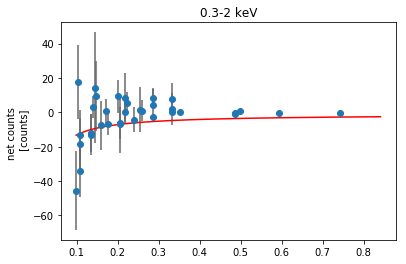

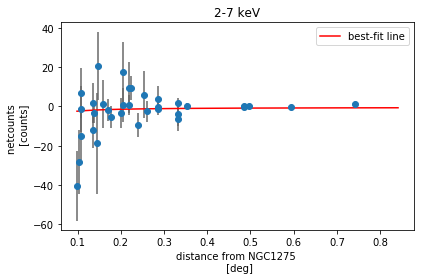

array([[ 0.33927932, -0.5657304 ],
       [-0.5657304 ,  0.96539871]])

In [90]:
fig1 = plt.figure()                # create common figure
fig2 = plt.figure()
bestpars300,parscov300 = leastsquares(x, y_300, yerr300)     # for .3-2 keV
bestpars2000,parscov2000 = leastsquares(x, y_2000, yerr2000) # for 2-7 keV

ax1 = fig1.add_subplot(111)
ax1.errorbar(x, y_300, yerr300, linestyle="none", marker='o', ecolor='#666666', label='$0.3-2.0 keV$')
x_grid = np.linspace(x.min(), x.max()+0.1, 128)
ax1.plot(x_grid, f_model(bestpars300[::-1], x_grid), marker='', linestyle='-', color='r', label='best-fit line')


ax2 = fig2.add_subplot(111)
ax2.errorbar(x, y_2000, yerr2000, linestyle='none', marker='o', ecolor='#666666')
ax2.plot(x_grid, f_model(bestpars2000[::-1], x_grid), marker='', linestyle='-', color='r', label='best-fit line')

ax1.set_title('0.3-2 keV')
#ax1.set_xlabel('distance from NGC1275 \n [deg]')
ax1.set_ylabel('net counts \n [counts]')


ax2.set_title('2-7 keV')
ax2.set_xlabel('distance from NGC1275 \n [deg]')
plt.ylabel('netcounts \n [counts]')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

parscov300